In [1]:
# Khai báo thư viện
import pandas as pd
import numpy as np
import math
import time
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from itertools import cycle
from plotly.subplots import make_subplots
from datetime import datetime,timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# Các lớp để xây dựng mô hình
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import SimpleRNN

# Kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [26]:
# Các hàm hỗ trợ
# Hàm kiểm tra 2 tham số truyền vào có là sublist
def sublist(lst1, lst2):
    return set(lst1) <= set(lst2)

# Hàm scale dữ liệu về [0;1]
def scale_data(data_train=None, data_test=None, target=None, scale_back=False, scaler=None, data=None):
    if not scale_back:
        target_scaler = MinMaxScaler().fit(data_train[target])
        data_train[target] = target_scaler.transform(data_train[target])
        data_test[target] = target_scaler.transform(data_test[target])
        return target_scaler, data_train[target], data_test[target]

    if len(data.shape) == 3:
        nsamples, nx, ny = data.shape
        y_pred = data.reshape((nsamples,nx*ny))
        y_pred = scaler.inverse_transform(y_pred)[:,-1]
        y_pred = y_pred.reshape(-1,1)
    else:
        y_pred = scaler.inverse_transform(data)

    return y_pred

# Hàm xây dựng dữ liệu: X_train, y_train, X_test, y_test
def build_data(data, look_back, features, target):
    X, y = [], []

    for i in range(look_back, data.shape[0]):
        if(sublist(target,features)):
            X.append(data[features].iloc[i - look_back: i])
        else:
            X.append(data[features + target].iloc[i - look_back: i])
        y.append(data[target].iloc[i])

    X, y = np.array(X), np.array(y)
    return X, y

# Hàm fit X_train, y_train. Sau đó evaluate X_test, y_test ứng với model truyền vào
# Trả về model để thực hiện predict
def model_training(model, X_train, y_train, X_test, y_test):
    model.compile(optimizer='adam', loss='mean_squared_error')
    train_history=model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)
    model.evaluate(X_test, y_test, verbose=0)
    
    return train_history

In [11]:
# Đọc dữ liệu
# Path: /content/drive/MyDrive/Colab Notebooks/Stock Price Prediction/data/VIC.csv
df1 = pd.read_csv("./data/VIC.csv")
df2 = pd.read_csv("./data/MSN.csv")
df3 = pd.read_csv("./data/PNJ.csv")
df4 = pd.read_csv("./data/FPT.csv")

# Tạo dataframe mới
df = pd.concat([df1, df2, df3, df4])
df.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,VIC,10/17/2018 9:39,98.5,98.5,98.5,98.5,390,0
1,VIC,10/17/2018 9:40,98.5,98.5,98.5,98.5,760,0
2,VIC,10/17/2018 9:41,98.6,98.6,98.6,98.6,2060,0
3,VIC,10/17/2018 9:42,98.6,98.6,98.6,98.6,5540,0
4,VIC,10/17/2018 9:43,98.6,98.7,98.6,98.7,760,0


In [12]:
# Chuẩn hóa dữ liệu
df = df.rename(columns={'Date/Time': 'date'})
df.columns = df.columns.str.lower()
df = df.drop(df.columns[-1], axis=1) # Xóa bỏ cột dư thừa
df['date'] = pd.to_datetime(df['date']).dt.date
df.sort_values(by='date', inplace=True) # Sắp xếp theo ngày
df.head()

,ticker,date,open,high,low,close,volume
0,MSN,2017-12-25,73.1,73.1,73.1,73.1,4210
33,MSN,2017-12-25,73.2,73.2,73.2,73.2,230
34,MSN,2017-12-25,73.3,73.3,73.3,73.3,50
35,MSN,2017-12-25,73.3,73.3,73.3,73.3,440
36,MSN,2017-12-25,73.4,73.5,73.4,73.5,6200


In [13]:
# Tổng quan bộ dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 459335 entries, 0 to 97405
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ticker  459335 non-null  object 
 1   date    459335 non-null  object 
 2   open    459335 non-null  float64
 3   high    459335 non-null  float64
 4   low     459335 non-null  float64
 5   close   459335 non-null  float64
 6   volume  459335 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 28.0+ MB


In [20]:
# Chọn mã cổ phiếu
ticker = 'VIC'
data = df.groupby('ticker').get_group(ticker).groupby('date').mean()
data.head()

,open,high,low,close,volume
date,,,,,
2018-10-17,98.645833,98.679762,98.615476,98.645238,7539.345238
2018-10-18,98.658011,98.697238,98.640331,98.666298,4951.049724
2018-10-19,97.586772,97.634392,97.556614,97.602646,4845.873016
2018-10-22,99.153333,99.203333,99.130556,99.165556,2982.944444
2018-10-23,98.295402,98.345977,98.265517,98.312644,3498.563218


In [21]:
# Trích xuất đặc trưng
target = ['close']
features = ['open','close','low','high']

if (sublist(target, features)):
  df_ticker = data[features]
else:
  df_ticker = data[features + target]

print(f'Các đặc trưng dùng để dự đoán {target} của mã cổ phiếu {ticker}:')
df_ticker.head()

Các đặc trưng dùng để dự đoán ['close'] của mã cổ phiếu VIC:


,open,close,low,high
date,,,,
2018-10-17,98.645833,98.645238,98.615476,98.679762
2018-10-18,98.658011,98.666298,98.640331,98.697238
2018-10-19,97.586772,97.602646,97.556614,97.634392
2018-10-22,99.153333,99.165556,99.130556,99.203333
2018-10-23,98.295402,98.312644,98.265517,98.345977


In [22]:
# Dùng 1 tuần trong quá khứ dể dự đoán 2 tuần tiếp theo
look_back = 7
days_predict = 14

# Tách dữ liệu
split = df_ticker.shape[0]-(days_predict+look_back)
df_train = df_ticker.iloc[:split, :].copy()
df_test = df_ticker.iloc[split:, :].copy()

print("Dữ liệu tập tổng thể:",df_ticker.shape)
print("Dữ liệu tập training:",df_train.shape)
print("Dữ liệu tập testing:",df_test.shape)

Dữ liệu tập tổng thể: (548, 4)
Dữ liệu tập training: (527, 4)
Dữ liệu tập testing: (21, 4)


In [23]:
# Scale dữ liệu
target_scaler, df_train[target], df_test[target] = scale_data(df_train, df_test, target)
features_scaler, df_train[features], df_test[features] = scale_data(df_train, df_test, features)

In [24]:
print(f'Dữ liệu Train sau khi scale về [0;1]:\n {df_train.head()}')
print(f'\nDữ liệu Test sau khi scale về [0;1]:\n {df_test.head()}')

Dữ liệu Train sau khi scale về [0;1]:
                 open     close       low      high
date                                              
2018-10-17  0.493154  0.493426  0.493728  0.493028
2018-10-18  0.493384  0.493823  0.494195  0.493357
2018-10-19  0.473209  0.473801  0.473811  0.473327
2018-10-22  0.502712  0.503220  0.503416  0.502895
2018-10-23  0.486554  0.487166  0.487145  0.486738

Dữ liệu Test sau khi scale về [0;1]:
                 open     close       low      high
date                                              
2020-11-24  0.587620  0.587826  0.587827  0.587648
2020-11-25  0.619868  0.619999  0.619849  0.619964
2020-11-26  0.615602  0.615819  0.615943  0.615492
2020-11-27  0.621009  0.621268  0.621447  0.620910
2020-11-30  0.597974  0.597847  0.597821  0.597987


In [25]:
# Chuẩn bị dữ liệu X_train, y_train, X_test, y_test
X_train, y_train = build_data(df_train, look_back, features, target)
X_test, y_test = build_data(df_test, look_back, features, target)

In [27]:
# Xây dựng mô hình
model = Sequential()
model.add(SimpleRNN(units=32, input_shape=(X_train.shape[1:]), return_sequences=True))
model.add(SimpleRNN(units=32))
model.add(Dense(units=1))

In [30]:
# Sử dụng mô hình để dự đoán tập train
time_start = time.time()
y_train_predict = model.predict(X_train)
training_time_rnn = time.time() - time_start
print(f'Thời gian dự đoán tập train: {round(training_time_rnn,3)}s')

17/17 [==============================] - 0s 5ms/step
Thời gian dự đoán tập train: 0.214s


In [29]:
# Sử dụng mô hình để dự đoán tập Test
time_start = time.time()
y_test_predict = model.predict(X_test)
testing_time_rnn = time.time() - time_start
print(f'Thời gian dự đoán tập test: {round(testing_time_rnn,3)}s')

1/1 [==============================] - 0s 300ms/step
Thời gian dự đoán tập test: 0.37s


In [31]:
# Do scailing nên khi so sánh thì ta phải đổi các giá trị về lại dạng gốc
y_train = scale_data(scale_back=True, scaler=target_scaler, data=y_train) # Dữ liệu thực
y_train_predict = scale_data(scale_back=True, scaler=target_scaler, data=y_train_predict) # Dự liệu dự đoán

y_test = scale_data(scale_back=True, scaler=target_scaler, data=y_test) # Dữ liệu thực
y_test_predict = scale_data(scale_back=True, scaler=target_scaler, data=y_test_predict) # Dữ liệu dự đoán

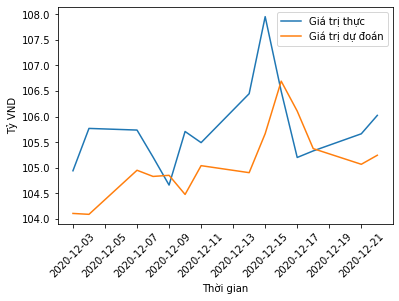

In [43]:
# Đánh giá mô hình
data = data.reset_index()
data=data['date'][-days_predict:]
plt.figure()
plt.ylabel("Tỷ VND")
plt.xlabel("Thời gian")
plt.plot(data,y_test)
plt.plot(data,y_test_predict)
plt.legend(['Giá trị thực','Giá trị dự đoán'])
plt.xticks(rotation=45)
print()